In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import torch

def eval(model,x_test,y_test, nn = None):
    if nn == None:
        print(classification_report(y_test,model.predict(x_test)))
    else:
        y_pred = model(torch.tensor(x_test.astype(np.float32)))
        y_pred  = y_pred.cpu().detach().numpy() 
        y_pred = (y_pred > 0.5)
        y_pred  = np.asarray(y_pred, dtype=np.int32)
        print(classification_report(y_test,y_pred))
    

In [2]:
data = pd.read_csv('water_potability.csv')

In [3]:
data.describe()

ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.594320    32.879761   8768.570828     1.583085    41.416840   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.093092   176.850538  15666.690297     6.127421   307.699498   
50%       7.036752   196.967627  20927.833607     7.130299   333.073546   
75%       8.062066   216.667456  27332.762127     8.114887   359.950170   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3114.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.390110  
std       80.824064        3.308162        16.175008     0.780382     0.487849  
min      181.483754        2.200000         0.738000     1.450000     0.000000  
25%      365.734414       12.065801        55.844536     3.439711     0.000000  
50%      421.884968       14.218338        66.622485     3.955028     0.000000  
75%      481.792304       16.557652        77.337473     4.500320     1.000000  
max      753.342620       28.300000       124.000000     6.739000     1.000000

In [4]:
data = data.dropna()

<AxesSubplot:>

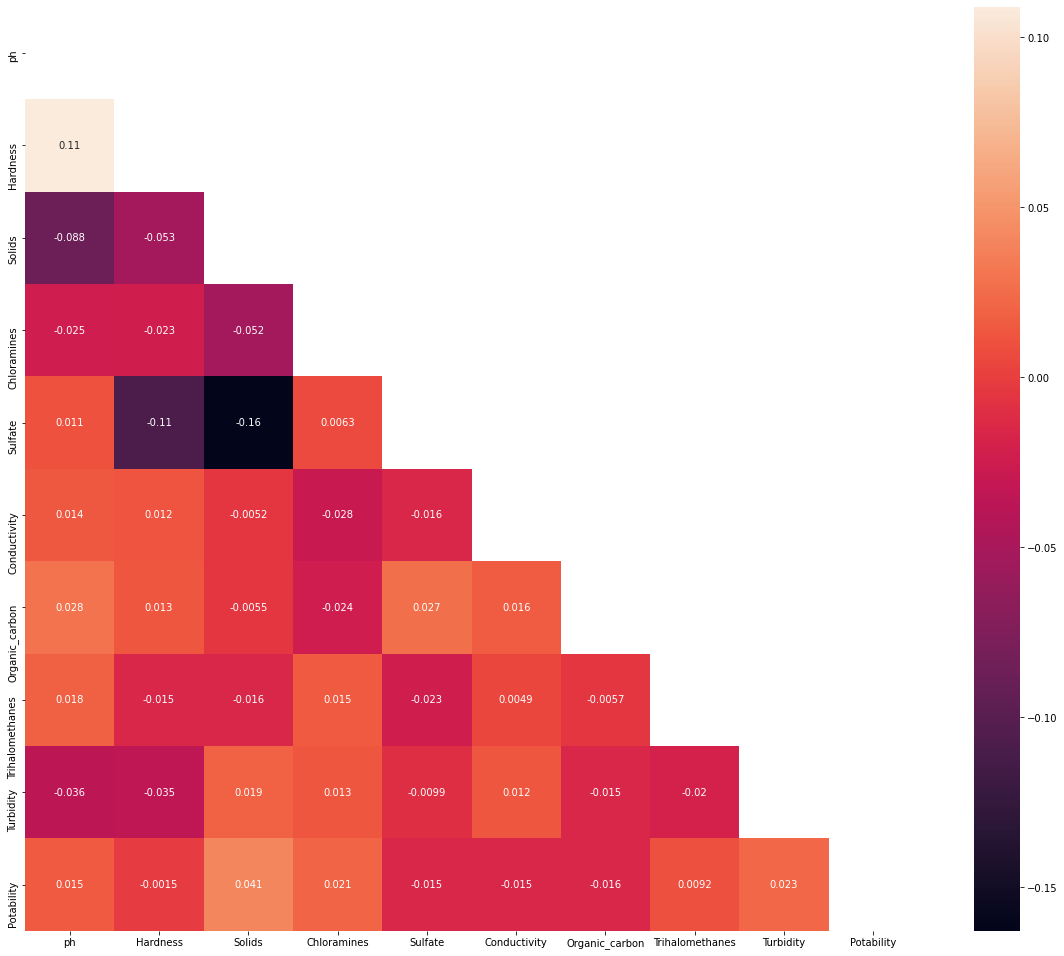

In [5]:
plt.figure(figsize=(20,17))
matrix = np.triu(data.corr())
sns.heatmap(data.corr(), annot=True, linewidth=0, mask=matrix)

In [6]:
data_feat = data.iloc[:, :-1]
data_target = data.iloc[:, -1]
st = StandardScaler()
data_feat = st.fit_transform(data_feat)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(data_feat, data_target, random_state = 42, test_size = 0.1)

In [22]:
DT = DecisionTreeClassifier(criterion = 'gini').fit(X_train, Y_train)

In [23]:
eval(DT,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.72      0.67      0.69       123
           1       0.53      0.59      0.56        79

    accuracy                           0.64       202
   macro avg       0.63      0.63      0.63       202
weighted avg       0.65      0.64      0.64       202



In [10]:
SV =  SVC(gamma='scale').fit(X_train, Y_train)

In [11]:
eval(SV,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.70      0.93      0.80       123
           1       0.78      0.39      0.52        79

    accuracy                           0.72       202
   macro avg       0.74      0.66      0.66       202
weighted avg       0.73      0.72      0.69       202



In [12]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                              eval_metric='logloss',
                              use_label_encoder = False,
                              booster='gbtree',reg_lambda=3).fit(X_train, Y_train)

In [13]:
eval(xgb_model,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.67      0.72      0.69       123
           1       0.50      0.44      0.47        79

    accuracy                           0.61       202
   macro avg       0.58      0.58      0.58       202
weighted avg       0.60      0.61      0.60       202



In [24]:
kn = KNeighborsClassifier(n_neighbors=1,
                             algorithm='kd_tree').fit(X_train, Y_train)

In [25]:
eval(kn,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.67      0.71      0.69       123
           1       0.50      0.46      0.48        79

    accuracy                           0.61       202
   macro avg       0.58      0.58      0.58       202
weighted avg       0.60      0.61      0.61       202



In [40]:
class NeuralNetworkModel(torch.nn.Module):

    def __init__(self):
        super(NeuralNetworkModel, self).__init__()
        self.fc1 = torch.nn.Linear(9,2000)
        self.fc2 = torch.nn.Linear(2000,1000)
        self.fc3 = torch.nn.Linear(1000,1)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x
    
model_nn = NeuralNetworkModel()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model_nn.parameters(), lr=0.01)
 
batch_size = 3

 
for epoch in range(6):
    loss_score = 0
    acc_score = 0
    items_total = 0
    model_nn.train()
    for i in range(0, Y_train.to_numpy().shape[0], batch_size):
        X = X_train[i:i+batch_size]
        X = torch.tensor(X.astype(np.float32))
        Y = Y_train[i:i+batch_size].to_numpy()
        Y = torch.tensor(Y.astype(np.float32)).reshape(-1,1)
 
        Y_predictions = model_nn(X)
        acc_score += torch.sum((Y_predictions > 0.5) == Y).item()
        items_total += Y.shape[0] 

        optimizer.zero_grad()
        loss = criterion(Y_predictions, Y)
        loss.backward()
        optimizer.step()


        loss_score += loss.item() * Y.shape[0]

In [41]:
eval(model_nn,X_test,Y_test, 1)

              precision    recall  f1-score   support

           0       0.70      0.89      0.78       123
           1       0.70      0.41      0.51        79

    accuracy                           0.70       202
   macro avg       0.70      0.65      0.65       202
weighted avg       0.70      0.70      0.68       202



In [18]:
class LogisticRegressionModel(torch.nn.Module):

    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.fc = torch.nn.Linear(9,1)

    def forward(self, x):
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x
    
lr_model = LogisticRegressionModel()
BATCH_SIZE = 2
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(lr_model.parameters(), lr = 0.1)
loss_score = 0
acc_score = 0
items_total = 0
lr_model.train()
for i in range(0, Y_train.shape[0], BATCH_SIZE):
    X = X_train[i:i+BATCH_SIZE]
    X = torch.tensor(X.astype(np.float32))
    Y = Y_train[i:i+BATCH_SIZE].to_numpy()
    Y = torch.tensor(Y.astype(np.float32)).reshape(-1,1)
    Y_predictions = lr_model(X)
    acc_score += torch.sum((Y_predictions > 0.5) == Y).item()
    items_total += Y.shape[0] 
    
    optimizer.zero_grad()
    loss = criterion(Y_predictions, Y)
    loss.backward()
    optimizer.step()
    

    loss_score += loss.item() * Y.shape[0] 

In [19]:
eval(lr_model,X_test,Y_test, 1)

              precision    recall  f1-score   support

           0       0.63      0.80      0.71       123
           1       0.47      0.28      0.35        79

    accuracy                           0.59       202
   macro avg       0.55      0.54      0.53       202
weighted avg       0.57      0.59      0.57       202

